In [ ]:
import math
import torch
import scipy.special as sc
from scipy.stats import chi2
import random
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def _invSqrt(A):
        vals, vecs = torch.linalg.eigh(A)
        return vecs @ torch.diag(1.0 / torch.sqrt(vals)) @ vecs.T

@torch.no_grad()
def rTensorNorm(n, M, Sigma1, Sigma2, Sigma3):
    p1 = Sigma1.shape[0]
    p2 = Sigma2.shape[0]
    p3 = Sigma3.shape[0]
    e1_vals, e1_vecs = torch.linalg.eigh(Sigma1)
    sqrtSigma1 = e1_vecs @ torch.diag(torch.sqrt(e1_vals)) @ e1_vecs.T
    e2_vals, e2_vecs = torch.linalg.eigh(Sigma2)
    sqrtSigma2 = e2_vecs @ torch.diag(torch.sqrt(e2_vals)) @ e2_vecs.T
    e3_vals, e3_vecs = torch.linalg.eigh(Sigma3)
    sqrtSigma3 = e3_vecs @ torch.diag(torch.sqrt(e3_vals)) @ e3_vecs.T
    Z = torch.randn(n, p1, p2, p3, device=device)
    Z = Z.view(n * p1 * p2, p3) @ sqrtSigma3
    Z = Z.view(n, p1, p2, p3)
    Z = Z.permute(0, 1, 3, 2).contiguous()
    Z = Z.view(n * p1 * p3, p2) @ sqrtSigma2
    Z = Z.view(n, p1, p3, p2)
    Z = Z.permute(0, 3, 2, 1).contiguous()
    Z = Z.view(n * p2 * p3, p1) @ sqrtSigma1
    Z = Z.view(n, p2, p3, p1)
    Z = Z.permute(0, 3, 1, 2).contiguous()
    M_expanded = M.unsqueeze(0).expand(n, p1, p2, p3)
    Z = Z + M_expanded
    return Z

@torch.no_grad()
def computeTensorMD(C, invSqrt1, invSqrt2, invSqrt3, returnContributions=False):
    n, p1, p2, p3 = C.shape
    C = C.view(n * p1 * p2, p3) @ invSqrt3
    C = C.view(n, p1, p2, p3)
    C = C.permute(0, 1, 3, 2).contiguous()
    C = C.view(n * p1 * p3, p2) @ invSqrt2
    C = C.view(n, p1, p3, p2)
    C = C.permute(0, 3, 2, 1).contiguous()
    C = C.view(n * p2 * p3, p1) @ invSqrt1
    C = C.view(n, p2, p3, p1)
    C = C.permute(0, 3, 1, 2).contiguous()
    D = C * C
    D = D.view(n, -1)
    TMDsq = D.sum(dim=1)
    if returnContributions:
        D = D.view(n, p1, p2, p3)
        return TMDsq, D
    else:
        return TMDsq

@torch.no_grad()
def updateOneCov(C, invSqrt2, invSqrt3):
    n, p1, p2, p3 = C.shape
    C = C.view(n * p1 * p2, p3) @ invSqrt3
    C = C.view(n, p1, p2, p3)
    C = C.permute(0, 1, 3, 2).contiguous()
    C = C.view(n * p1 * p3, p2) @ invSqrt2
    C = C.view(n, p1, p3, p2)
    C = C.permute(1, 0, 3, 2).contiguous()
    C = C.view(p1, n * p2 * p3)
    Sigma1 = (C @ C.T) / (n * p2 * p3)
    return Sigma1





@torch.no_grad()
def flipFlopMLE(C1, C2, C3,
                Sigma1init, Sigma2init, Sigma3init,
                invSqrt2init, invSqrt3init,
                maxIter,
                tol):

    old1 = Sigma1init
    old2 = Sigma2init
    old3 = Sigma3init
    invSqrt2 = invSqrt2init
    invSqrt3 = invSqrt3init
    for it in range(maxIter):
        Sigma1 = updateOneCov(C1, invSqrt2, invSqrt3)
        invSqrt1 = _invSqrt(Sigma1)
        Sigma2 = updateOneCov(C2, invSqrt3, invSqrt1)
        invSqrt2 = _invSqrt(Sigma2)
        Sigma3 = updateOneCov(C3, invSqrt1, invSqrt2)
        d11_1 = Sigma1[0, 0]
        d11_2 = Sigma2[0, 0]
        Sigma1 = Sigma1 / d11_1
        Sigma2 = Sigma2 / d11_2
        Sigma3 = Sigma3 * (d11_1 * d11_2)
        if it == maxIter - 1:
            break
        frobDiff = torch.sum((Sigma1 - old1) ** 2) \
                 + torch.sum((Sigma2 - old2) ** 2) \
                 + torch.sum((Sigma3 - old3) ** 2)
        if frobDiff < tol:
            break
        invSqrt3 = _invSqrt(Sigma3)
        old1 = Sigma1
        old2 = Sigma2
        old3 = Sigma3
    return {
        "Sigma1": Sigma1,
        "Sigma2": Sigma2,
        "Sigma3": Sigma3,
        "invSqrt1": invSqrt1,
        "invSqrt2": invSqrt2
    }

@torch.no_grad()
def cStep(X, C, Sigma1, Sigma2, Sigma3,
          invSqrt1, invSqrt2, invSqrt3,
          alpha,
          maxIterC,
          tolC,
          maxIterFF,
          tolFF):
    def _ld(S1, S2, S3):
        return (p2 * p3) * torch.logdet(S1) \
             + (p1 * p3) * torch.logdet(S2) \
             + (p1 * p2) * torch.logdet(S3)
    n, p1, p2, p3 = X.shape
    h = int(math.floor(alpha * n))
    ldOld = _ld(Sigma1, Sigma2, Sigma3)
    for it in range(maxIterC):
        TMDsAll = computeTensorMD(C, invSqrt1, invSqrt2, invSqrt3)
        sortedIdx = torch.argsort(TMDsAll)
        subsetIndices = sortedIdx[:h]
        Xsub = X[subsetIndices]
        subMean = Xsub.mean(dim=0)
        C1 = Xsub - subMean
        C2 = C1.permute(0, 2, 3, 1).contiguous()
        C3 = C1.permute(0, 3, 1, 2).contiguous()
        initFF = flipFlopMLE(
            C1, C2, C3,
            Sigma1, Sigma2, Sigma3,
            invSqrt2, invSqrt3,
            maxIterFF,
            tolFF
        )
        Sigma1 = initFF["Sigma1"]
        Sigma2 = initFF["Sigma2"]
        Sigma3 = initFF["Sigma3"]
        invSqrt1 = initFF["invSqrt1"]
        invSqrt2 = initFF["invSqrt2"]
        ldNew = _ld(Sigma1, Sigma2, Sigma3)
        if it == maxIterC - 1 or abs(ldNew - ldOld) < tolC:
            break
        ldOld = ldNew
        C = X - subMean
        vals, vecs = torch.linalg.eigh(Sigma3)
        invSqrt3 = vecs @ torch.diag(1.0 / torch.sqrt(vals)) @ vecs.T
    return {
        "Sigma1": Sigma1,
        "Sigma2": Sigma2,
        "Sigma3": Sigma3,
        "invSqrt1": invSqrt1,
        "invSqrt2": invSqrt2,
        "subsetIndices": subsetIndices,
        "TMDsAll": TMDsAll,
        "ld": ldNew
    }

@torch.no_grad()
def tmcd(X,
         alpha,
         nSubsets,
         nBest,
         maxIterCshort,
         maxIterFFshort,
         maxIterCfull,
         maxIterFFfull,
         tolC,
         tolFF,
         beta):

    n, p1, p2, p3 = X.shape
    s = int(math.ceil(p1/(p2*p3) + p2/(p1*p3) + p3/(p1*p2))) + 2
    allSubsets = []
    for _ in range(nSubsets):
        allSubsets.append(torch.randperm(n)[:s].to(device))
    shortResults = []
    for i in range(nSubsets):
        idx = allSubsets[i]
        xSub = X[idx]
        subMean = xSub.mean(dim=0)
        C1 = xSub - subMean
        C2 = C1.permute(0, 2, 3, 1).contiguous()
        C3 = C1.permute(0, 3, 1, 2).contiguous()
        initSig1 = torch.eye(p1, device=device)
        initSig2 = torch.eye(p2, device=device)
        initSig3 = torch.eye(p3, device=device)
        initInvSqrt2 = torch.eye(p2, device=device)
        initInvSqrt3 = torch.eye(p3, device=device)
        shortMLE = flipFlopMLE(
            C1, C2, C3,
            initSig1, initSig2, initSig3,
            initInvSqrt2, initInvSqrt3,
            maxIterFFshort,
            tolFF
        )
        C = X - subMean
        curInvSqrt3 = _invSqrt(shortMLE["Sigma3"])
        shortRes = cStep(
            X, C,
            shortMLE["Sigma1"],
            shortMLE["Sigma2"],
            shortMLE["Sigma3"],
            shortMLE["invSqrt1"],
            shortMLE["invSqrt2"],
            curInvSqrt3,
            alpha,
            maxIterCshort,
            tolC,
            maxIterFFshort,
            tolFF
        )
        shortResults.append(shortRes)
    allLd = torch.tensor([res["ld"] for res in shortResults], device=device)
    rankLd = torch.argsort(allLd)
    topIdx = rankLd[:min(nBest, nSubsets)]
    fullResults = []
    for j in range(len(topIdx)):
        chosen = shortResults[topIdx[j]]
        xSub = X[chosen["subsetIndices"]]
        subMean = xSub.mean(dim=0)
        C = X - subMean
        invSqrt3 = _invSqrt(chosen["Sigma3"])
        fullRes = cStep(
            X, C,
            chosen["Sigma1"],
            chosen["Sigma2"],
            chosen["Sigma3"],
            chosen["invSqrt1"],
            chosen["invSqrt2"],
            invSqrt3,
            alpha,
            maxIterCfull,
            tolC,
            maxIterFFfull,
            tolFF
        )
        fullResults.append(fullRes)
    allLdFull = torch.tensor([r["ld"] for r in fullResults], device=device)
    bestFullIdx = torch.argmin(allLdFull)
    bestRaw = fullResults[bestFullIdx]
    dfMain = p1 * p2 * p3
    dfPlus = dfMain + 2
    chiAlpha = chi2.ppf(alpha, dfMain)
    cdfVal = chi2.cdf(chiAlpha, dfPlus)
    gammaAlpha = alpha / cdfVal
    S1 = bestRaw["Sigma1"]
    S2 = bestRaw["Sigma2"]
    S3 = bestRaw["Sigma3"] * gammaAlpha
    invSqrt2 = bestRaw["invSqrt2"]
    vals3, vecs3 = torch.linalg.eigh(S3)
    invSqrt3 = vecs3 @ torch.diag(1.0 / torch.sqrt(vals3)) @ vecs3.T
    TMDsqAll = bestRaw["TMDsAll"]
    cutoff = chi2.ppf(beta, dfMain)
    goodSet = torch.where((TMDsqAll / gammaAlpha) < cutoff)[0]
    finalGood = torch.unique(torch.cat([bestRaw["subsetIndices"], goodSet]))
    outliers = torch.tensor(list(set(range(n)) - set(finalGood.tolist())), device=device)
    Xgood = X[finalGood]
    M = Xgood.mean(dim=0)
    alphaHat = float(len(finalGood)) / n
    C1 = Xgood - M
    C2 = C1.permute(0, 2, 3, 1).contiguous()
    C3 = C1.permute(0, 3, 1, 2).contiguous()
    ffFinal = flipFlopMLE(
        C1, C2, C3,
        S1, S2, S3,
        invSqrt2, invSqrt3,
        maxIterFFfull,
        tolFF
    )
    S1 = ffFinal["Sigma1"]
    S2 = ffFinal["Sigma2"]
    S3 = ffFinal["Sigma3"]
    chiAlphaHat = chi2.ppf(alphaHat, dfMain)
    cdfValHat = chi2.cdf(chiAlphaHat, dfPlus)
    gammaAlphaHat = alphaHat / cdfValHat
    S3 = S3 * gammaAlphaHat
    return {
        "M": M,
        "Sigma1": S1,
        "Sigma2": S2,
        "Sigma3": S3,
        "outliers": outliers,
        "finalGood": finalGood
    }



In [ ]:
import time, torch, zipfile, os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

zip_path = "/content/tensor_dataset.zip"
assert os.path.exists(zip_path), "tensor_dataset.zip not found!"

with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall("/content")


dataset_uint8 = torch.load("/content/tensor_dataset.pt", map_location="cpu")
X_full = dataset_uint8.to(torch.float32) / 255.0
X_full = X_full.to(device).contiguous()

n, p1, p2, p3 = X_full.shape
print(f"Loaded dataset   : {n} clips  ({p1}×{p2}×{p3})")
print(f"Tensor dtype/dev : {X_full.dtype} / {X_full.device}\n")



Loaded dataset   : 223 clips  (144×256×240)
Tensor dtype/dev : torch.float32 / cuda:0



In [ ]:

X_full = X_full[..., ::2].contiguous()
n, p1, p2, p3 = X_full.shape

print(f"After decimation : {n} clips  ({p1}×{p2}×{p3})\n")

del dataset_uint8
torch.cuda.empty_cache()


After decimation : 223 clips  (144×256×120)



In [ ]:

start = time.perf_counter()
tmcd_res = tmcd(
    X_full,
    alpha          = 0.75,
    nSubsets       = 500,
    nBest          = 20,
    maxIterCshort  = 2,
    maxIterFFshort = 2,
    maxIterCfull   = 50,
    maxIterFFfull  = 100,
    tolC           = 1e-4,
    tolFF          = 1e-3,
    beta           = 0.9999
)
if torch.cuda.is_available():
    torch.cuda.synchronize()
elapsed = time.perf_counter() - start


good   = tmcd_res["finalGood"].numel()
outliers = sorted(tmcd_res["outliers"].cpu().tolist())

print(f"TMCD finished   – good clips: {good} / {n}")
print(f"Elapsed time    : {elapsed:.2f} s")
print(f"Outlier indices : {outliers}")


TMCD finished   – good clips: 167 / 223
Elapsed time    : 649.82 s
Outlier indices : [20, 43, 44, 45, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 102, 106, 115, 118, 120, 145]


In [ ]:
print(f"Outlier clips : {[i + 1 for i in outliers]}")

Outlier clips : [21, 44, 45, 46, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 103, 107, 116, 119, 121, 146]


In [ ]:
# Mahalanobis distances (descending order)
idx_list = [20, 43, 44, 45, 52, 53, 54, 97, 98, 102, 106, 115, 118, 120]

pairs = [(i, round(TMDsq_all[i].item())) for i in idx_list]
pairs.sort(key=lambda x: x[1], reverse=True)

for i, md2 in pairs:
    print(f"Clip {i+1:3d} : {md2:9d}")



Clip  54 : 441311744
Clip  98 : 261269024
Clip  55 : 204941344
Clip  99 :  61201852
Clip  53 :  24560764
Clip  21 :  22066482
Clip  44 :  18224316
Clip  45 :  15834776
Clip 119 :   8752306
Clip  46 :   8409096
Clip 107 :   7810924
Clip 116 :   7512534
Clip 121 :   7458789
Clip 103 :   7327364


Selected outliers: [43, 44, 53, 66, 93, 75, 77, 61, 97, 106]


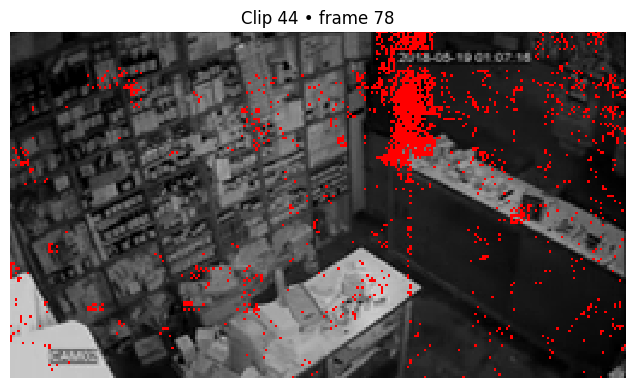

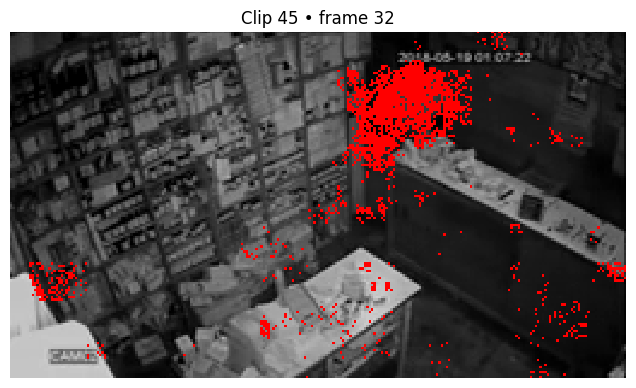

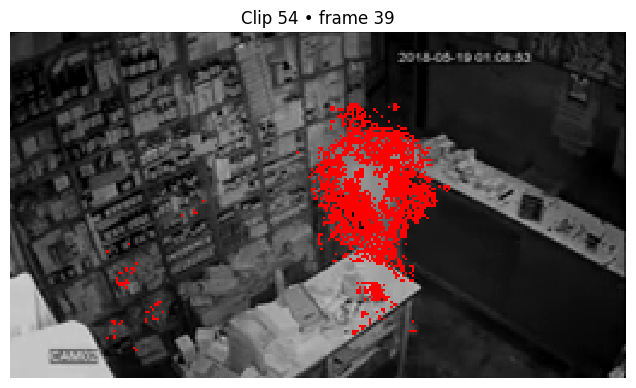

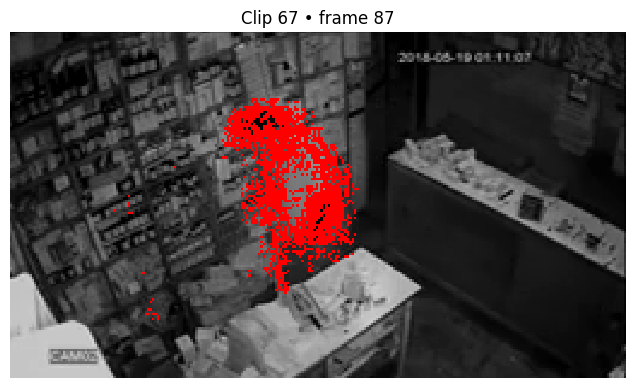

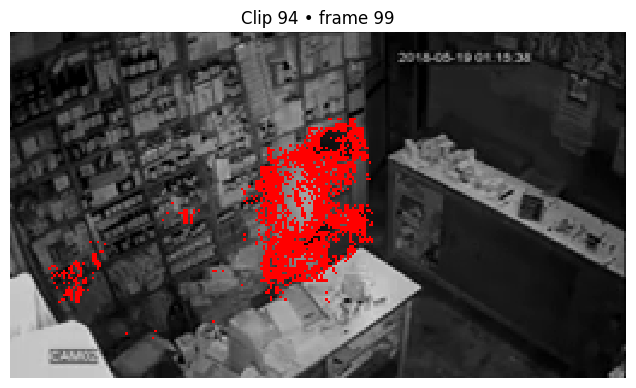

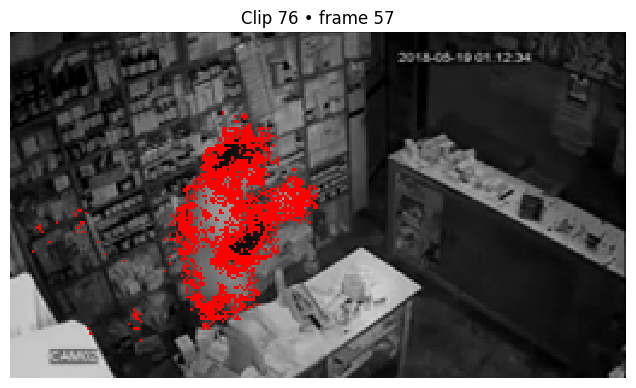

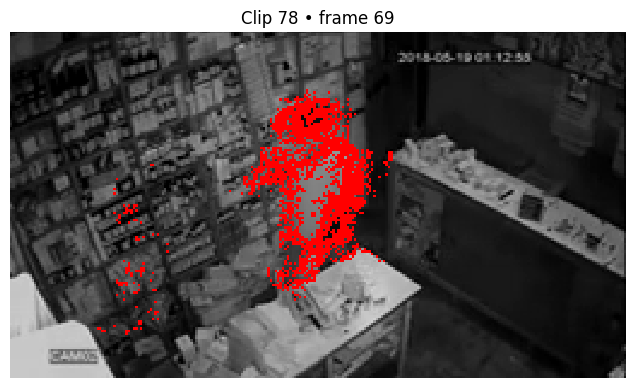

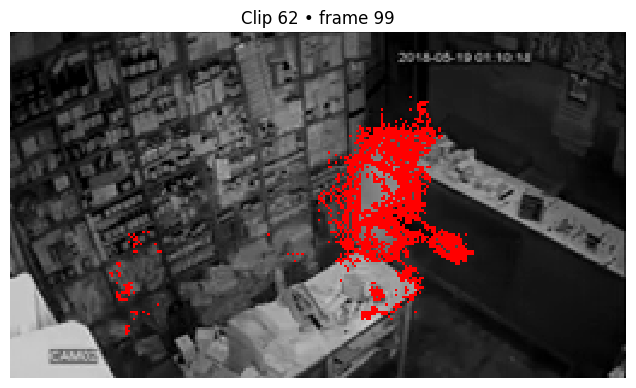

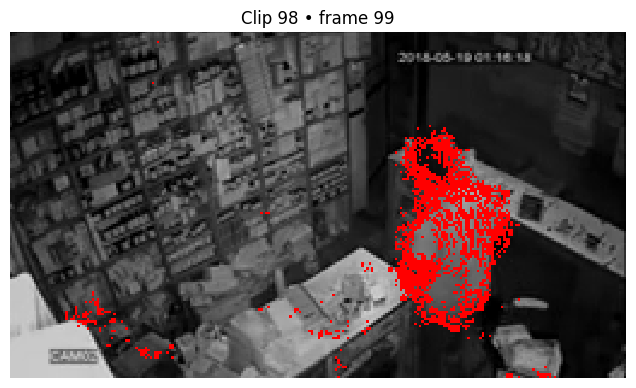

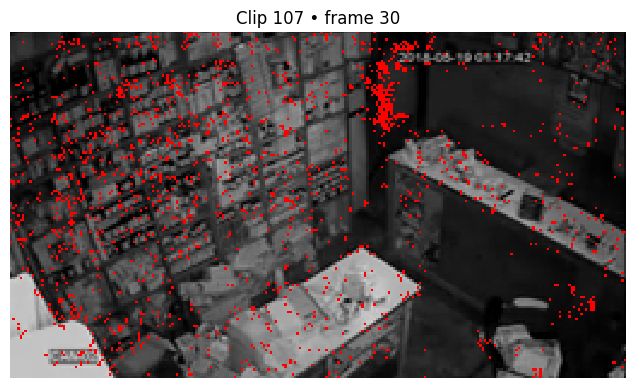

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt

# Mahalanobis distances --------------------------------------------------------
invSqrt1 = _invSqrt(tmcd_res["Sigma1"])
invSqrt2 = _invSqrt(tmcd_res["Sigma2"])
invSqrt3 = _invSqrt(tmcd_res["Sigma3"])
with torch.no_grad():
    TMDsq_all = computeTensorMD(X_full, invSqrt1, invSqrt2, invSqrt3)

outlier_idx = torch.sort(tmcd_res["outliers"]).values       # ascending

first_pair     = outlier_idx[1:3]                           # #2 and #3
remaining      = torch.cat((outlier_idx[:1], outlier_idx[3:]))
_, top_pos     = torch.topk(TMDsq_all[remaining], k=8, largest=True)
rest_eight     = remaining[top_pos]                         # by MD desc
rest_seven     = rest_eight[:7]                             # keep 7 of 8
last_special   = outlier_idx[-5].unsqueeze(0)               # penultimate idx

sel_idx_gpu = torch.cat((first_pair, rest_seven, last_special))
sel_idx     = sel_idx_gpu.cpu().tolist()
print("Selected outliers:", sel_idx)

def show_hottest_frame(idx):
    clip = X_full[idx]
    _, D = computeTensorMD((clip - tmcd_res["M"]).unsqueeze(0),
                           invSqrt1, invSqrt2, invSqrt3,
                           returnContributions=True)
    D = D.squeeze(0)
    j_star = torch.argmax(D.sum(dim=(0,1))).item()
    mask   = D[..., j_star] >= torch.quantile(D[..., j_star], 0.95)
    frame  = clip[..., j_star].cpu().numpy()
    rgb    = np.stack([frame]*3, axis=-1)
    rgb[mask.cpu().numpy()] = [1., 0., 0.]
    plt.figure(figsize=(8, 4.5))
    plt.imshow(rgb, interpolation="nearest")
    plt.title(f"Clip {idx+1} • frame {j_star+1}")            # +1 for display
    plt.axis("off")
    plt.show()

for idx in sel_idx:
    show_hottest_frame(idx)


In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np, torch
from matplotlib import font_manager

alpha = 0.1
ttf   = font_manager.findfont("DejaVu Sans")
font  = ImageFont.truetype(ttf, size=12)

invSqrt1 = _invSqrt(tmcd_res["Sigma1"])
invSqrt2 = _invSqrt(tmcd_res["Sigma2"])
invSqrt3 = _invSqrt(tmcd_res["Sigma3"])

def overlay_frame(idx):
    clip = X_full[idx]
    _, D = computeTensorMD((clip - tmcd_res["M"]).unsqueeze(0),
                           invSqrt1, invSqrt2, invSqrt3,
                           returnContributions=True)
    D = D.squeeze(0)
    j_star = torch.argmax(D.sum(dim=(0,1))).item()

    mask  = D[..., j_star] >= torch.quantile(D[..., j_star], 0.95)
    frame = clip[..., j_star].cpu().numpy()
    rgb   = np.stack([frame]*3, axis=-1)
    rgb[mask.cpu().numpy()] = (1-alpha)*rgb[mask.cpu().numpy()] + alpha*np.array([1,0,0])

    img  = Image.fromarray((rgb*255).astype(np.uint8))
    draw = ImageDraw.Draw(img)

    label         = f"clip {idx+1} | frame {j_star+1}"
    w_txt, h_txt  = draw.textbbox((0,0), label, font=font)[2:]
    pad_x, pad_y  = 4, 2                                 # minimal padding
    y0            = img.height - h_txt                   # flush to bottom
    draw.rectangle([(0, y0-pad_y), (w_txt+2*pad_x, img.height)], fill=(0,0,0))
    draw.text((pad_x, y0), label, fill="white", font=font)  # baseline on bottom edge
    return img

imgs   = [overlay_frame(i) for i in sel_idx]
h, w   = imgs[0].size[1], imgs[0].size[0]
canvas = Image.new("RGB", (w*2, h*5))
for k, im in enumerate(imgs):
    r, c = divmod(k, 2)
    canvas.paste(im, (c*w, r*h))

pdf_path = "/content/top10_outliers_alpha01.pdf"
canvas.save(pdf_path, "PDF")
print("saved:", pdf_path)


saved: /content/top10_outliers_alpha01.pdf


In [ ]:
import gc

for var in list(globals().values()):
    if hasattr(var, 'iterator') and hasattr(var, 'num_workers'):
        var._iterator._shutdown_workers()
for k in list(globals().keys()):
    obj = globals()[k]
    if torch.is_tensor(obj) or isinstance(obj, torch.nn.Module):
        del globals()[k]


gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
print("allocated :", torch.cuda.memory_allocated() / 1024**2, "MB")
print("reserved  :", torch.cuda.memory_reserved()  / 1024**2, "MB")


allocated : 25.38720703125 MB
reserved  : 44.0 MB


In [ ]:
del tensors_and_models
gc.collect()
torch.cuda.empty_cache()


NameError: name 'tensors_and_models' is not defined